In [1]:
import numpy as np
import librosa
from IPython.display import Audio, display
from matplotlib import pyplot as plt
import soundfile as sf
from mystft import stft, istft

import sys
import os
# Add upper directory
current_dir = os.path.dirname(os.path.abspath('demo_stft_ola.ipynb'))
upper_dir = (os.path.join(current_dir, '..'))
sys.path.append(upper_dir)
from utils_global import draw_spec


### STFT

In [2]:
hop_length = 768
win_length = 1024
siglen = 40000
n_fft = 1024
y = np.random.randn(siglen)
######################
# Comparison with librosa
D = librosa.stft(y, n_fft=n_fft, window='hamming', win_length=win_length, hop_length=hop_length)
librosa_frames = D.shape[1]
print(D[0,:4])
print(D[0,-4:])
print(f"librosa STFT Frame num: {librosa_frames}\n")

D = stft(y, n_fft=n_fft, win_type='hamming', win_length=win_length, hop_length=hop_length, plot=False)
librosa_frames = D.shape[1]
print(D[0,:4])
print(D[0,-4:])
print(f"Implemented STFT Frame num: {librosa_frames}")


[  4.60601924+0.j -23.78686544+0.j  14.43822416+0.j   7.09101097+0.j]
[  0.86024036+0.j -35.16475788+0.j -37.84241918+0.j   2.65953264+0.j]
librosa STFT Frame num: 53

[  4.60601924+0.j -23.78686544+0.j  14.43822416+0.j   7.09101097+0.j]
[  0.86024036+0.j -35.16475788+0.j -37.84241918+0.j   2.65953264+0.j]
Implemented STFT Frame num: 53


(257, 107) (257, 107)
Implemented
[0.1402778  0.50447765 1.48364676 0.45122995 0.39031896]
[0.14420682 1.57233161 2.20098878 1.38702051 0.49879998]
[0.1439153  2.19100689 1.39091596 1.56896569 0.61931117]
Reference
[0.1402778  0.5044777  1.4836468  0.45122996 0.39031896]
[0.1442068 1.5723314 2.2009885 1.3870205 0.4988   ]
[0.1439153  2.191007   1.390916   1.5689657  0.61931115]


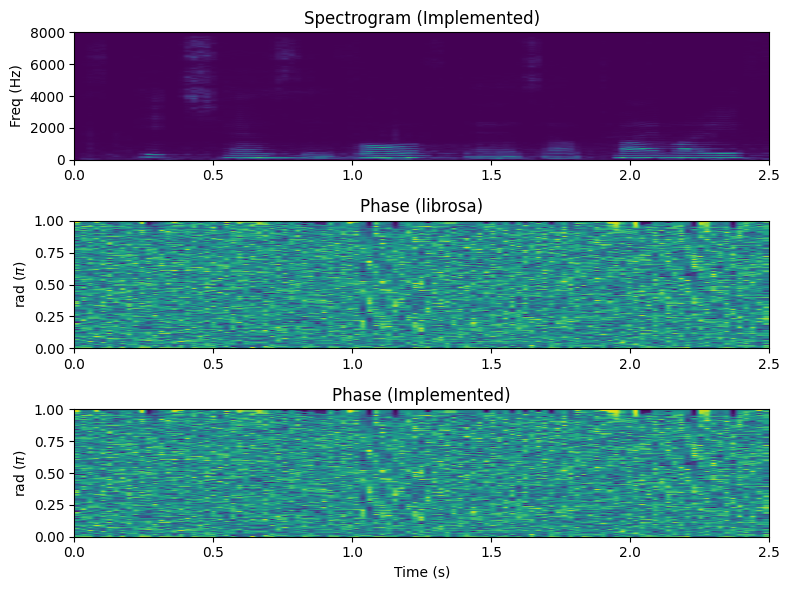

In [3]:
# Usage
hop_length = 375
win_length = 500
n_fft = 512
siglen = 40000
sr = 16000
#########################
filename = librosa.ex('trumpet')
y, sr = librosa.load(filename)
y, sr = librosa.load("./sample_crop_16kHz.wav", sr=None)

spec = stft(y, sr=sr, win_type='hamming', win_length=win_length, hop_length=hop_length, n_fft=n_fft, plot=False)
spec_librosa = librosa.stft(y, window='hamming', win_length=win_length, hop_length=hop_length, n_fft=n_fft)
print(spec.shape, spec_librosa.shape)

# Phase
phase1 = np.angle(spec) / np.pi
phase2 = np.angle(spec_librosa) / np.pi
spec, spec_librosa = np.abs(spec), np.abs(spec_librosa)

print('Implemented')
for freqaxis in range(3):
    print(spec[freqaxis,:5])
print('Reference')
for freqaxis in range(3):
    print(spec_librosa[freqaxis,:5])

# Plot Spectrogram 
plt.figure(figsize=(8,6))
plt.subplot(3,1,1)
# plt.figure(figsize=(8,2))
plt.imshow(np.abs(spec), aspect='auto', 
                cmap='viridis', 
                origin='lower', extent=[0, 2.5, 0, sr//2])
# plt.colorbar()
plt.ylabel(r"Freq (Hz)")
plt.title("Spectrogram (Implemented)")
# plt.show()

# Plot Phase Spectra
plt.subplot(3,1,2)
# plt.figure(figsize=(8,2))
plt.imshow(phase1, aspect='auto', 
                cmap='viridis', 
                origin='lower', extent=[0, 2.5, 0, 1])
# plt.colorbar()
plt.ylabel(r"rad ($\pi$)")
plt.title("Phase (librosa)")
# plt.show()

plt.subplot(3,1,3)
# plt.figure(figsize=(8,2))
plt.imshow(phase2, aspect='auto', 
                cmap='viridis', 
                origin='lower', extent=[0, 2.5, 0, 1])
# plt.colorbar()
plt.ylabel(r"rad ($\pi$)")
plt.title("Phase (Implemented)")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

## ISTFT with OLA

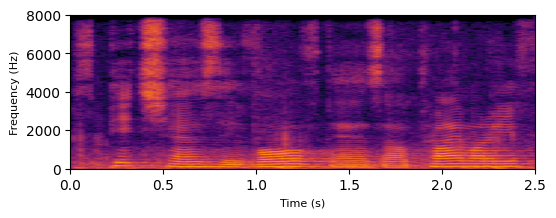

40000


In [4]:
""" 2.5 sec speech data """
path = "sample_crop_16kHz.wav"
y, sr = librosa.load(path, sr=16000)

t = draw_spec(y, sr=sr, use_colorbar=False, figsize=(6,2), return_fig=False)
display(Audio(y,rate=sr))
print(len(y))

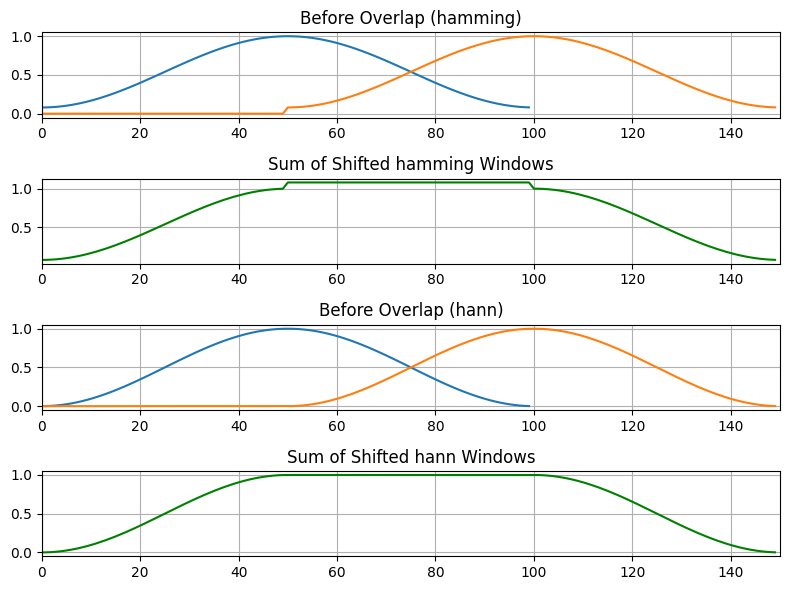

In [5]:
i=1
plt.figure(figsize=(8, 6))

for window in ['hamming', 'hann']:
    hann_window = librosa.filters.get_window(window,100)
    # Shift the Hann window by 50 samples
    buffer = np.zeros(150)
    buffer[:100] = hann_window
    buffer[50:] += hann_window

    shift_hann = np.concatenate([np.zeros(50), np.array(hann_window)])

    # Plot the original, shifted, and summed windows

    # Plot the original Hann window
    plt.subplot(4, 1, i)
    plt.plot(hann_window, label='Before Overlap')
    plt.plot(shift_hann, label='Original Hann Window')
    plt.title(f'Before Overlap ({window})')
    plt.grid(True)
    plt.xlim(0, 150)

    # Plot the sum of the original and shifted Hann windows
    plt.subplot(4, 1, i+1)
    plt.plot(buffer, label='Sum of Original and Shifted Hann', color='green')
    plt.title(f'Sum of Shifted {window} Windows')
    plt.grid(True)
    plt.xlim(0,150)
    plt.tight_layout()
    
    i+=2
plt.show()
    

In [16]:
def overlapadd(frames, win_length, hop_length, win_type='hann', griffin=True):
    """ 
    OLA process
    input: 
        frames: frame list with [NumFrames]
        win_type: Window array or string type of window
    """
    num_frames = len(frames)
    siglen = win_length + (num_frames - 1) * hop_length
    y = np.zeros(siglen)
    window_sum = np.zeros(siglen)
    
    # Generate window if win_type is a string; otherwise, use the provided array
    if isinstance(win_type, str):
        try:
            window = librosa.filters.get_window(win_type, win_length)
        except ValueError:
            raise ValueError("Unsupported window type!")
    else:
        window = win_type  # Assume win_type is already an array with proper padding
    
    for frame_idx in range(num_frames):
        start = frame_idx * hop_length
        frame = frames[frame_idx]
        if griffin:
            y[start:start + win_length] += frame * window
            window_sum[start:start + win_length] += window ** 2
        else:
            y[start:start+win_length] += frame
            window_sum[start:start+win_length] += window
    
    # Normalize by window overlap factor
    y /= np.where(window_sum > 1e-10, window_sum, 1e-10)

    # crop out to remove paddings (center-based STFT)
    y = y[win_length//2:-win_length//2]
    window_sum = window_sum[win_length//2:-win_length//2]
    return y


def istft(Y_w, win_length, hop_length, n_fft, win_type='hann', griffin=True):
    """
    ISTFT Implementation identical to librosa.istft     
    ** Returns:
        y_buffer: Reconstructed time-domain signal
    """
    if not n_fft:
        n_fft = win_length  # Default to win_length if n_fft is not provided
        
    if win_length < hop_length:
        raise ValueError(f"win_length ({win_length}) must be greater than or equal to hop_length ({hop_length})")
    if n_fft < win_length:
        raise ValueError(f"n_fft ({n_fft}) must be greater than or equal to win_length ({win_length})")

    # Generate window with padding if win_length < n_fft
    try:
        window = librosa.filters.get_window(win_type, win_length)
    except ValueError:
        raise ValueError("Unsupported window type!")
    padlen = n_fft - win_length
    padded_window = np.pad(window, (padlen // 2, padlen // 2), mode='constant')

    # Reconstruct Y to get full spectrum in frequency axis
    Y_flip = np.flipud(Y_w)[1:-1]
    Y_w = np.concatenate((Y_w, np.conj(Y_flip)), axis=0)  # Note that phase is odd
    
    num_frames = Y_w.shape[1]
    frames = []

    # Calculate each frame by inverse FFT
    for frame_idx in range(num_frames):
        frame = np.real(np.fft.ifft(Y_w[:, frame_idx]))  # Inverse FFT
        frames.append(frame)

    # Use overlapadd with padded window to combine frames
    y_buffer = overlapadd(frames, win_length=n_fft, hop_length=hop_length, win_type=padded_window, griffin=griffin)
    return y_buffer


Length of waveform:(40000,) Shape of Spec:(513, 167)


original: (40000,)


reconstructed: (39840,)


library: (39840,)


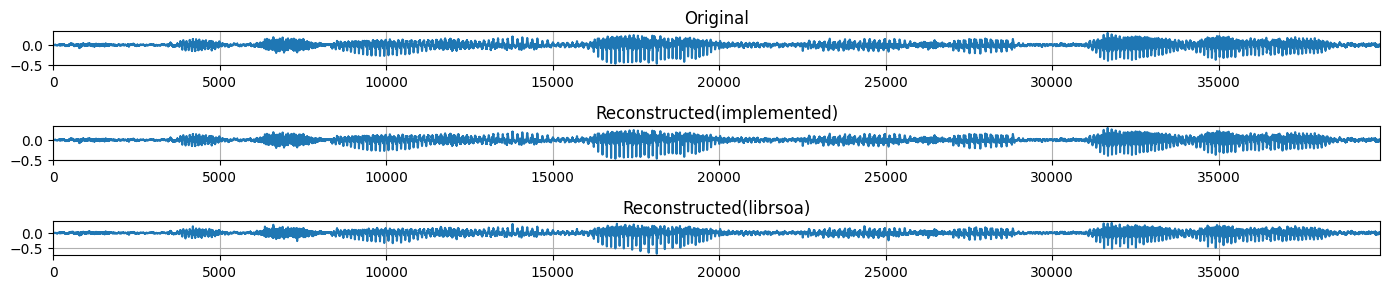

Implemented
[-0.00024414 -0.00094604 -0.00112915 -0.00140381 -0.00216675 -0.00396729
 -0.00375366 -0.00396729 -0.003479   -0.00210571]
Reference Librosa
[-0.00024414 -0.00094605 -0.00112919 -0.00140391 -0.00216702 -0.00396805
 -0.00375471 -0.00396879 -0.00348073 -0.00210703]


In [22]:
# Load & STFT
hop_length = 240
n_fft = 1024
win_length = 320
window = 'hamming'
y, sr = librosa.load('sample_crop_16kHz.wav', sr=16000)

spec = stft(y, sr=sr, win_type=window, win_length=win_length, hop_length=hop_length, n_fft=n_fft)
print(f'Length of waveform:{y.shape} Shape of Spec:{spec.shape}')

# ISTFT
yhat = istft(spec, win_length=win_length, hop_length=hop_length, win_type=window, n_fft=n_fft, griffin=True)
yhat_lib = librosa.istft(spec, win_length=win_length, hop_length=hop_length, n_fft=n_fft)

display(Audio(y, rate=16000))
print('original:', y.shape)
display(Audio(yhat, rate=16000))
print('reconstructed:', yhat.shape)
display(Audio(yhat_lib, rate=16000))
print('library:', yhat_lib.shape)

# Plot
plt.figure(figsize=(14,3))
plt.subplot(3,1,1)
plt.xlim(0,len(yhat))
plt.grid()
plt.title("Original")
plt.plot(y)

plt.subplot(3,1,2)
plt.plot(yhat)
plt.xlim(0,len(yhat))
plt.grid()
plt.title("Reconstructed(implemented)")

plt.subplot(3,1,3)
plt.plot(yhat_lib)
plt.xlim(0,len(yhat_lib))
plt.grid()
plt.title("Reconstructed(librsoa)")

plt.tight_layout()
plt.show()

# plt.plot(win)
# plt.xlim(0,len(win))
# print(len(win))
# print(win[:10])
# plt.show()

# plt.figure(figsize=(14,3))
# plt.plot(yhat-y)
# plt.xlim(0,len(yhat_lib))
# plt.grid()
# plt.title("Reconstructed(librsoa)")
# print(np.sum((yhat-y)**2))

print('Implemented')
print(yhat[:10])
print('Reference Librosa')
print(yhat_lib[:10])